Recently, I ran into an interesting video on YouTube on numerical methods (at this pont, I can't help but wonder if YouTube can read my mind, but now I digress). It was a channel called [numericalmethodsguy](https://www.youtube.com/channel/UCtXs16H04R0SSeRI8UEXMxw), run by a professor of mechanical engineering at the University of Florida. While the videos themselves were recorded a while back in 2009 at just 240p, I found the contents of the video to be very intriguing and easily digestable. His videos did not seem to assume much mathematical knowledge beyond basic high school calculus. After watching a few of his videos, I decided to implement some numerical methods algorithms in Python. Specifically, this post will deal with mainly two methods of solving non-linear equations: the Newton-Raphson method and the secant method. Let's dive right into it.

# Equation Representation

Before we move on, it's first necessary to come up with a way of representing equations in Python. For the sake of simplicity, let's first just consider polynomials. 

The most obvious, simplest way of representing polynomials in Python is to simply use functions. For example, we can express $f(x) = x^3 - 20$ as

In [108]:
def f(x):
    return x ** 3 - 20

However, a downside of this approach is the fact that it's difficult to directly derive this equation despite the fact that it is nothing more than just a simple polynomial. 

## List Representation

So instead, we will use a list index-based representation. Namely, the  $i$th element of a list represents the coefficient of the $i$th power in a polynomial equation. In other words, $f(x) = x^2 - 20$ would translate into `[-20, 0, 0, 1]`. The `make_function()` is a function that returns a Python function given a list that conforms to this list index representation.

In [39]:
def make_function(f_array):
    return lambda x: sum(
        coef * x ** power for power, coef in enumerate(f_array)
    )

Let's see if this works as expected. 

In [40]:
f_array = [-20, 0, 0, 1]
f = make_function(f_array)
f(3)

7

$3^3 - 20 = 7$, so the function passes our quick sanity test. 

## Parser

One useful helper function that I also implemented for the sake of convenience is a array-to-equation parser that translates a list representation into a mathematical expression in Python. This is best demonstrated than explained, so I'll defer myself to an exampe.

In [47]:
parsed_string = parse(f_array)
parsed_string

'1 * x ** 3 - 20'

Below is the full definition of the `parse()` function. 

In [46]:
def parse(f_array):
    if len(f_array) == 0:
        raise ValueError("`f_array` should contain at least one term.")
    res = ""
    for power, coef in zip(range(len(f_array) - 1, -1, -1), reversed(f_array)):
        if coef == 0:
            continue
        if power == 0:
            res += f" + {coef}" if coef > 0 else f" - {abs(coef)}"
        else:
            res += (
                f" + {coef} * x ** {power}"
                if coef > 0
                else f" - {abs(coef)} * x ** {power}"
            )
    if f_array[-1] > 0:
        return res[3:]
    return res[1:]

## Evaluate

At this point, I also thought that it would be useful and interesting to compose a function that translates the string output of `parse()` into a proper Python function we can use to calculate values. Below is the `evaluate()` function that receives as input some parsed output string and returns a corresponding Python function.

In [37]:
def evaluate(string, x):
    return eval(string.replace("x", str(x)))

Now, we can do something like this:

In [111]:
print(f"f(x) = {parsed_string}")
print(f"f(5) = {evaluate(parsed_string, 5)}")

f(x) = 1 * x ** 3 - 20
f(5) = 105


# Calculus and Approximations

Now that we have more than enough tools we can use relating to the list index representation we decided to use to represent polynomials, it's time to exploit the convenience that this representation affords us to calculate derivatives. 

## Direct Approach

Calculating derivatives using the list index representation is extremely easy and convenient: in fact, it can be achieved in just a single line. 

In [41]:
def derive(f_array):
    '''
    Input: list index representation of a function
    Output: derivative in list index representation
    '''
    return [power * coef for power, coef in enumerate(f_array)][1:]

Let's test this function with the `f_array` example we have been using previously. Let's also use the `parse()` function to make the final result for human-readable.

In [113]:
print(f"f(x) = {parse(f_array)}")
print(f"f'(x) = {parse(derive(f_array))}")

f(x) = 1 * x ** 3 - 20
f'(x) = 3 * x ** 2


Seems like the derivative calculation works as expected. 

In the process, I got a little bit extra and also wrote a function that integrates a function in list index representation format. 

In [43]:
f_prime = make_function(f_prime_array)
f_prime(3)

27

In [44]:
def integrate(f_array):
    res = [0]
    for power, coef in enumerate(f_array):
        res.append(coef / (power + 1))
    return res

If we integrate $f(x) = x^3 - 20$, we end up with $F(x) = \frac14 x^4 - 20 x + C$, where $C$ is the integration constant. Excluding the integration constant, we get a result that is consistent with the `integrate()` function.

In [115]:
print(f"F(x) = {parse(integrate(f_array))}")

F(x) = 0.25 * x ** 4 - 20.0 * x ** 1


While it's great that we can calcuate derivatives and integrals, one very obvious drawback of this direct approach is that we cannot deal with non-polynomial functions, such as exponentials or logarithms. Moreover, the list index representation is unable to represent polynomials that include terms whose powers are not positive integers. For these reasons, we will need some other methods of calculating derivatives as well. Hence the motivation for approximation methods, outlined in the section below.

## Approximation

If you probe the deepest depths of your memory, somewhere you will recall the following equation, which I'm sure all of us saw in some high school calculus class:

$$
f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h} \tag{1}
$$

This equation, commonly known as the definition of a derivative, is also known as the forward divided difference formula of calcuating derivatives. There is another variant, known as the backward divided difference formula:

$$
f'(x) = \lim_{h \to 0} \frac{f(x) - f(x - h)}{h} \tag{2}
$$

(1) and (2) are almost nearly identical, but the difference lies in which term is subtracted from who. In (1), we go an infinitesimal step forward---hence the $f(x + h)$---and subtract the value at the point of approximation, $f(x)$. In (2), we go backwards, which is why we get $f(x - h)$. As $h$ approaches 0, (1) and (2) asymptotically gives us identical results. 

Below is a Python variant of the backward divided difference formula. Some tweaks have been made to the formula for use in the section that follows, but at its core, it's clear that the function uses the approximation logic we've discussed so far.

In [26]:
def backward_divided_difference(f, x_current, x_prev):
    return (f(x_current) - f(x_prev)) / (x_current - x_prev)

Another variant of the forward and backward divided difference formula is the center divided difference. By now, you might have some intuition as to what this formula is---as the name implies, we somehow use the center point, instead of going forward or backwards from the point of approximation. Here is the formua:

$$
f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x - h)}{2h} \tag{3}
$$

Heuristically, this formula also makes sense. We can imagine going both a step forward and backward, then dividing the results by the total of two steps we've taken, one in each direction. 

Shown below is the Python implementation of the center divided difference formula. 

In [67]:
def center_divided_difference(f, x, epsilon=1e-5):
    return (f(x + epsilon) - f(x - epsilon)) / (2 * epsilon)

## Error Bounds

According to conventional mathematical wisdom, the center divided method normally provides a more robust way of approximating first order derivatives. In this subsection, we discuss why this is the case. 

Using Taylor expansion, we can approximate the value of $f(a + h)$ as follows, given that $h$ goes to 0 under the limit.

$$
\begin{align}
f(a + h) 
&= f(a) + f'(a)h + \frac{f^{(2)}(a)}{2!} h^2 + \cdots \\
&= \sum_{k = 0}^\infty \frac{f^{(k)}(a)}{k!} h^k
\end{align} \tag{4}
$$

Notice that we can manipulate (4) to derive the forward divided difference equation in (1). If we move the $f(a)$ term to the LHS, then divide both sides by $h$, we end up with

$$
\begin{align}
\frac{f(a + h) - f(a)}{h} 
&= f'(a) + \frac{f^{(2)}(a)}{2!} h + \frac{f^{(3)}(a)}{3!} h^2 + \cdots \\
&= f'(a) + O(h)
\end{align} \tag{5}
$$

Here, we used big-O notation to denote the order of magnitude of the trailing terms. The trailing terms are significant since they are directly related to the accuracy of our approximation. An error term of $O(h)$ means that, if we halve the step size, we will also halve the error. This is best understood as a linear relationship between error and the step size. 

We can conduct a similar mode of analysis with backward divided difference. By symmetry, we can express $f(a - h)$ as

$$
\begin{align}
f(a - h) 
&= f(a) + f'(a)(- h) + \frac{f^{(2)}(a)}{2!} (- h)^2 + \cdots \\
&= \sum_{k = 0}^\infty (- 1)^k \frac{f^{(k)}(a)}{k!} h^k
\end{align} \tag{6}
$$

If we rearrange (6), we end up with (2).

$$
\begin{align}
\frac{f(a) - f(a - h)}{h} 
&= f'(a) + \frac{f^{(2)}(a)}{2!} h - \frac{f^{(3)}(a)}{3!} h^2 + \cdots \\
&= f'(a) + O(h)
\end{align} \tag{7}
$$

Again, we see that backward divided difference yields linear error, or a trailing term of $O(h)$. 

Here's where things get more interesting: in the case of center divided difference, the magnitude of the error term is $O(h^2)$, meaning that halving the step size decreases the error by four-folds. This is why center divided difference yields much more accurate approximations than forward or backward divided difference. 

To see this, we subtract (5) from (4), then move some terms, and divide both sides by $2h$. Notice that subtracting these two expression results in a lot of term cancellations.

$$
f(a + h) - f(a - h) = 2 f'(a) h + 2 \frac{f^{(3)}(a)}{3!} h^3 + \cdots
$$

Dividing both sides by $2h$ yields

$$
\begin{align}
\frac{f(a + h) - f(a - h)}{2h} 
&= f'(a) + \frac{f^{(3)}(a)}{3!} h^2 + \cdots \\
&= f'(a) + O(h^2)
\end{align} \tag{8}
$$

From this result, we now know why the central divided difference method provides more accurate approximations of the derivative than do forward and backward divided difference. This is somewhat related to what we will be doing in the next section, so it's a good intuition to have throughout when reading the rest of this article.

Now that we have these tools for differential calculus, now comes the exciting part: solving non-linear equations. Specifically, we will be taking a look at two numerical methods: the Newton-Raphson method and the secant method.

# Numerical Methods

It's time to put the methods we developed in the preceding sections to use for solving non-linear equations. Sepcifically, we'll begin by taking look at a classic algorithm, the Newton-Raphson method.

## Newton-Raphson

The Newton-Raphson method is one of the many ways of solving non-linear equations. The intuition behind the Newton-Raphson method is pretty straightforward: we can use tangent lines to approximate the x-intercept, which is effectively the root of the equation $f(x) = 0$. Specifically, we begin on some point on the graph, then obtain the tangent line on that point. Then, we obtain the $x$-intercept of that tangent line, and repeat the process we've just completed by starting on a point on the graph whose $x$-value is equal to that $x$-intercept. The following [image](https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif) from Wikipedia illustrates this process quite well. (A digression: It's interesting to see how "function" and "tangent" are written in German---in case you are wondering, I don't know a word of German.)

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif">

### Derivation

Mathematically, the Newton-Raphson method can be expressed recursively as follows:

$$
x_{i + 1} = x_i - \frac{f(x_i)}{f'(x_i)} \tag{4}
$$

Deriving this formula is quite simple. Say we start at a point on the graph, $(x_i, f(x_i))$. The tangent line from that point will have a slope of $f'(x_i)$. Therefore, the equation of the tangent line can be expressed as 

$$
\begin{align}
y 
&= f'(x_i)(x - x_i) + f(x_i) \\
&= x f'(x_i) - x_i f'(x_i) + f(x_i)  \tag{5}
\end{align}
$$

Then, the $x$-intercept can simpy be obtained by finding an $x$ value that which makes $y = 0$. Let $x^*$ denote that point. Then, we arrive at the following update rule.

$$
0 = x^* f'(x_i) - x_i f'(x_i) + f(x_i) \\
\implies x^* = x_i - \frac{f(x_i)}{f'(x_i)}  \tag{6}
$$

Since we will be using $x^*$ as the value for the next iteration, $x^* = x_{i + 1}$, and now we have the update rule as delineated in (4). 

### Python Implementation

Below is an implementation of the Newton-Raphson method in Python. I've added some parameters to the function for functionality and customization. `epsilon` is simply some small value we use to decide when to stop the update; if the change in the value of the root is so small that it is not worth the extra compute, we should stop. `max_iter` determines how many iterations we want to continue. If the algorithm is unable to find the root within `max_iter` iterations, it likely means that the function provided does not have a root, or at the very least, the root is not discoverable via the algorithm. Lastly, `return_history` is a flag that determines whether we return the full update history or simply the last value in the iteration as a single valule. 

One peculiarity that deserves attention is the `TypeError` exception, which occurs in this case if the number of arguments passed into the function does not match. I added this `try` `except` block to take into account the fact that the `derive()` method and other approximate derivative calculation methods such as `center_divided_difference()` have differing numbers of parameters. 

In [64]:
def newton_raphson(
    f, f_prime, x, epsilon=1e-5, return_history=False, max_iter=100
):
    history = [x]
    for _ in range(max_iter):
        x_prev = history[-1]
        try:
            x = x - f(x) / f_prime(x)
        except TypeError:
            x = x - f(x) / f_prime(f, x)
        history.append(x)
        if abs(x - x_prev) < epsilon:
            return history if return_history else history[-1]
    raise RuntimeError("Exceeded `max_iter`.")

Let's see if this actually works by using the example we've been reusing thus far, $f(x) = x^3 - 20$, or `f` and `f_prime`, both of which we have already defined and initialized above.

In [65]:
root_nr = newton_raphson(f, f_prime, 3)
root_nr

2.7144176165949068

The root seems to be around 2.7. And indeed, if we cube it, we end up with a value extremely close to 20. In other words, we have successfully found the root to $y = x^3 - 20$. 

In [66]:
root_nr ** 3

20.000000000000004

Instead of the direct derivative, `f_prime`, we can also use approximation methods. In the example below, we show that using `center_divided_difference()` results in a very similar value (in fact, it is identical in this case, but we need to take into other factors such as numerical stability and overflow which might happen with such high-precision numbers).

In [69]:
root_nr_cdd = newton_raphson(f, center_divided_difference, 3)
root_nr_cdd

2.7144176165949068

This result aligns with the earlier observation that center divided difference provides very accurate approximations of the first derivative. 

Note that the advatage of using `center_divided_difference` is that we can now apply Newton-Raphson to non-polynomial equations that cannot be formulated in list index representation format. For instance, let's try something like `f(x) = e^x - 3`. 

In [116]:
import math

f2 = lambda x: math.exp(x) - 3
root_exp = newton_raphson(f2, center_divided_difference, 3)
root_exp

1.0986122886724257

To verify that this is indeed correct, we can plug `root_exp` back into `f2`. Also, given that $e \approx 2.7$, we can use some heuristics to realize that the answer must be only ever so slightly larger than 1. 

In [117]:
f2(root_exp)

1.2947865002388426e-11

Notice that the result is extremely close to zero, suggesting that we have found the correct root.

Now that we have seen the robustness of the Newton-Raphson method, let's take a look at another similar numerical method that uses backward divided difference for derivative approximation.

## Secant Method

In this section, we will look at the secant method, which is another method for identifying the roots of non-linear equations. Before we get into a description of how this method works, here's a quick graphic, again from [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/9/92/Secant_method.svg), on how the secant method works. 

<img src="https://upload.wikimedia.org/wikipedia/commons/9/92/Secant_method.svg">

As the name implies, the secant function works by drawing secant lines that cross the function at each iteration. Then, much like the Newton-Raphson method, we find the $x$-intercept of that secant line, find a new point on the graph whose $x$-coordinate corresponds to that intercept, and use the point from the previous iteration to find a new secant line. This process is very intuitively outlined in [this video by numericalmethodsguy](https://www.youtube.com/watch?v=UhW67ziXLhg).

### Derivation

The update rule for the secant method can be expressed as 

$$
x_{i + 1} = x_i - \frac{f(x_i)(x_i - x_{i - 1})}{f(x_i) - f(x_{i - 1})} \tag{7}
$$

We can derive (7) simply by slightly modifying the update rule we saw for Newton-Raphson. Recall that the Newton-Raphson update rule was written as 

$$
x_{i + 1} = x_i - \frac{f(x_i)}{f'(x_i)} \tag{4}
$$

The only modification we need to make to this update rule is to replace $f'(x_i)$ with an approximation using the backward divided difference formula. 

$$
f'(x) = \lim_{h \to 0} \frac{f(x) - f(x - h)}{h} \tag{2}
$$

Here, we make a slight modification to (2), specifically by using values from previous iterations.

$$
f'(x_i) = \frac{f(x_i) - f(x_{i - 1})}{x_i - x_{i - 1}} \tag{8}
$$

If we plug (8) back into (4), with some algebraic simplifications, we land on (7), the update rule for the secant method. This is left as an exercise for the reader.

### Python Implementation

Now let's take a look at how we might be able to implement this numerical method in code. Presented below is the `secant()` method, which follows the same general structure as the `newton_raphson()` function we looked at earlier. The only part that differs is the part where we use backward divided difference, which requires that we look up not only the immediately previous root approximation, but the value prior to that as well. In other words, we need both $x_i$ and $x_{i - 1}$ to calculate $x_{i + 1}$ via an iterative update.

In [57]:
def secant(
    f, x, epsilon=1e-5, init_step=0.5, return_history=False, max_iter=100
):
    if init_step < epsilon:
        raise ValueError("`init_step` cannot be smaller than `epsilon`.")
    history = [x + init_step, x]
    for _ in range(max_iter):
        x_prev, x = history[-2], history[-1]
        x_next = x - f(x) / backward_divided_difference(f, x, x_prev)
        history.append(x_next)
        if abs(x_next - x) < epsilon:
            return history if return_history else history[-1]
    raise RuntimeError("Exceeded `max_iter`.")

And here is an obligatory sanity check using our previous example. 

In [58]:
root_secant = secant(f, 3)
root_secant

2.714417616613744

2.7 is a familar value, and indeed it is what was returned by the Newton-Raphson method as well. We confirm that this is indeed the root of the equation.

In [59]:
root_secant ** 3

20.00000000041639

## Comparison

Now that we have looked at both methods, it's time to make a quick comparison. We will be comparing three different methods:

* Newton-Raphson method with direct polynomial derivatives
* Newton-Raphson method with center divided difference
* Secand method with backward divided difference

By setting `return_history` to be `True`, we can obtain a full list of root updates as the three methods begin their quest for the root of the function. We can then see which method converges the quickest. Let's see how this little experiment turns out.

We first begin by importing some dependencies to plot the history of values. 

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

Then, we obtain the history for each of the three approaches and plot them as a scatter plot. The result is shown below.

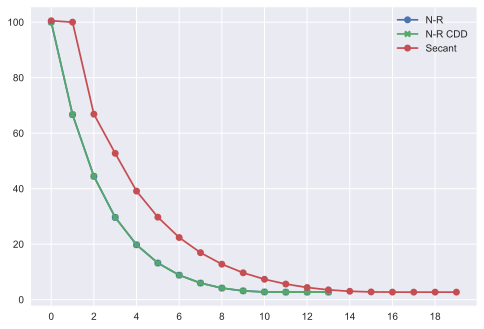

In [107]:
nr_history = newton_raphson(f, f_prime, 100, return_history=True)
nr_history_cdd = newton_raphson(f, center_divided_difference, 100, return_history=True)
secant_history = secant(f, 100, return_history=True)

plt.plot(range(len(nr_history)), nr_history, marker="o", label="N-R")
plt.plot(range(len(nr_history_cdd)), nr_history_cdd, marker="X", label="N-R CDD")
plt.plot(range(len(secant_history)), secant_history, marker="o", label="Secant")
plt.xticks(range(0, max(len(nr_history), len(nr_history_cdd), len(secant_history)), 2))
plt.legend()
plt.show()

You might have to squint your eye to see that `N-R` (Netwon-Raphson with direct derivatives) and `N-R CDD` (Newton-Raphson with center divided difference) almost coincide exactly at the same points. I was honestly somewhat surprised by the result: althought we had verified the advantage of using center divided difference over forward or backward divided difference via some simple big-O analysis with trailing error terms, I did not expect the two to coincide with such exactitude. 

Another interesting observation is that the secant method seems to take slightly longer than the Newton-Raphson method. This is probably due to the fact that the secant method uses backward divided difference, and also the fact that it requires two previous at each iteration instead of one. The reason why the first update seems rather ineffective is that the two initial guesses that we fed into the model was probably not such a good starting point. 

# Conclusion

The topic of today's post was somewhat different from what we had previously dealt with in this blog, but it was an interestig topic for me nonetheless. I had encountered the Newton-Raphson method previously when going down my typical Wikipedia rabbit holes, but it is only today that I feel like I've finally got a grasp of the concept. I condiser this post to be a start of many more posts on numerical methods to come. 

I hope you've enjoyed reading this post. See you in the next one.